# Analysing Scaling implemented by Green Grid Compass


*   Introduction
*   Variable selection
*   Loading and processing datasets
*   Daylight Savings Time handling
*   Calculating Scaling Factors and Plotting

# Introduction

This notebook analyses a crucial aspect of energy data processing before calculating CO2 emissions, implemented by the Green Grid Compass (GGC). Compensating for the discrepancy in the reporting of the generation data by the Transmission System Operators and other limitations is approached by scaling this generation data to statistical data by different sources. However, the scope of this analysis is to understand and visualize the scaling implemented by GGC for each production type. For the production types with an annual scaling factor, the raw scaling factor can be mapped but for the production types with monthly scaling factors, the scaling factor using net generation data from EUROSTAT can be calculated and compared with the raw scaling factor.

By comparing these data, this analysis aims to shed light on the scaling methodologies employed and their impact. The notebook can be used to load, process, and align these diverse datasets, and even account for the complexities of Daylight Savings Time. The visualizations generated offer a clear and intuitive understanding of these comparisons, making the analysis accessible and informative.

In [ ]:
!pip install entsoe-py
!pip install eurostatapiclient

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from entsoe import EntsoePandasClient
import requests
import os

# Variable selection
`variable_list` is a dictionary that aligns the generation types with the appropriate variable from the GGC data set to the ENTSO-E and EUROSTAT datasets. It also contains the resolution of the scaling i.e, either Annual (A) or Monthly (M). The generation type scaled on a monthly basis also contains the EUROSTAT Fuel code which ois later used to derive the values from the EUROSTAT Net Generation file to calculate the scaling factor as GGC's methodology suggests to compare both scaling factors.

Note: `variable_list` is written here manually, according to the table provided in GGC's methodology report.

In [ ]:
# Dictionary to align the generation types
variable_list = [
    {"Time": "A", "GGC": "Biomass", "ENTSOE": ('Biomass', 'Actual Aggregated'), "EUROSTAT": ""},
    {"Time": "A", "GGC": "Fossil_Brown_coal_Lignite", "ENTSOE": ('Fossil Brown coal/Lignite', 'Actual Aggregated'), "EUROSTAT": ""},
    {"Time": "A", "GGC": "Fossil_Gas", "ENTSOE": ('Fossil Gas', 'Actual Aggregated'), "EUROSTAT": ""},
    {"Time": "A", "GGC": "Fossil_Hard_Coal", "ENTSOE": ('Fossil Hard coal', 'Actual Aggregated'), "EUROSTAT": ""},
    {"Time": "A", "GGC": "Fossil_Oil", "ENTSOE": ('Fossil Oil', 'Actual Aggregated'), "EUROSTAT": ""},
    {"Time": "M", "GGC": "Geothermal", "ENTSOE": ('Geothermal', 'Actual Aggregated'), "EUROSTAT": "RA200"},
    {"Time": "A", "GGC": "Hydro_Pumped_Storage", "ENTSOE": ('Hydro Pumped Storage', 'Actual Aggregated'), "EUROSTAT": ""},
    {"Time": "A", "GGC": "Hydro_Run_of_river_poundage", "ENTSOE": ('Hydro Run-of-river and poundage', 'Actual Aggregated'), "EUROSTAT": "RA100"},
    {"Time": "A", "GGC": "Hydro_Water_Reservoir", "ENTSOE":  ('Hydro Water Reservoir', 'Actual Aggregated'), "EUROSTAT": "RA100"},
    {"Time": "A", "GGC": "Nuclear", "ENTSOE": ('Nuclear', 'Actual Aggregated'), "EUROSTAT": ""},
    {"Time": "M", "GGC": "Solar", "ENTSOE": ('Solar', 'Actual Aggregated'), "EUROSTAT": "RA420"},
    {"Time": "A", "GGC": "Waste", "ENTSOE": ('Waste', 'Actual Aggregated'), "EUROSTAT": ""},
    {"Time": "M", "GGC": "Wind_Offshore", "ENTSOE": ('Wind Offshore', 'Actual Aggregated'), "EUROSTAT": "RA320"},
    {"Time": "M", "GGC": "Wind_Onshore", "ENTSOE": ('Wind Onshore', 'Actual Aggregated'), "EUROSTAT": "RA310"}
]


# Loading and processing datasets
This section loads and processes the datasets.

1. **ENTSO-E Actual Generation Data**:
   - Retrieves generation data from ENTSO-E for the required year and all generation types using the `get_entsoe_data` function.
   - Saves the retrieved data as a parquet file in a local folder (`data`) to avoid redundant API calls.
   - Localizes the time to the 'Europe/Berlin' timezone, handling potential ambiguities and non-existent times.
   - If the parquet file already exists, it loads the data directly from the file.
2. **GGC Data (JSON)**:
   - Retrieves production data from GGC for the required year using the `get_ggc_data` function.
   - Saves the retrieved data as a parquet file in a local folder (`data`) to avoid redundant API calls.
   - Organizes the data into a dataframe.
   - Localizes the time to the 'Europe/Berlin' timezone, handling potential ambiguities and non-existent times.
   - If the parquet file already exists, it loads the data directly from the file.
3. **Eurostat Data (CSV)**:
   - A function `eurostat_net` is defined to retrieve Net Generation data for the required year and specific production types required for monthly scaling.
   - This data is aggregated for DE and LU over the months and retrieved later in the notebook for monthly scaling factor calculations.

Note: You would need to set the year according to your requirements and provide the API keys from GGC and ENTSO-E

In [ ]:

# Set variables required for further functions

year = 2023 # Set required year
start = pd.Timestamp(f'{year}-01-01 00:00', tz='Europe/Berlin')
end = pd.Timestamp(f'{year+1}-01-01 00:00', tz='Europe/Berlin')
country_code = "DE_LU"
ggc_key = <Your GGC API Key>
entsoe_key = <Your ENTSO-E API Key>


In [ ]:

# Function to retrieve ENTSO-E Data

def get_entsoe_data(year, start, end, country_code, entsoe_key):
  client = EntsoePandasClient(api_key=entsoe_key)
  monthly_data = []
  for month in range(1, 13):
    start = pd.Timestamp(f"{year}-{month:02d}-01", tz="Europe/Berlin")
    end = pd.Timestamp(f"{year}-{month%12+1:02d}-01", tz="Europe/Berlin") if month < 12 else pd.Timestamp(f"{year+1}-01-01", tz="Europe/Berlin")
    print(f"Fetching {start} to {end} ...")
    try:
      df = client.query_generation(
      country_code=country_code,
      start=start,
      end=end,
      psr_type=None
      )
      monthly_data.append(df)
    except Exception as e:
      print(f"Error fetching {start} to {end}: {e}")
  if monthly_data:
    entsoe_data = pd.concat(monthly_data)
    entsoe_data = entsoe_data[~entsoe_data.index.duplicated()]
    if entsoe_data.index.tz is None:
      entsoe_data.index = entsoe_data.index.tz_localize('Europe/Berlin', ambiguous='infer', nonexistent='shift_forward')
    entsoe_data = entsoe_data.sort_index()
    #optional: to analyse specific months
    #entsoe_data = entsoe_data[entsoe_data.index.month.isin([1,2])]
    return entsoe_data
  else:
    print("No data fetched")
    return pd.DataFrame()

# Function to retrieve GGC Data

def get_ggc_data(year, start, end, country_code, ggc_key, limit=3139):
  print("Fetching GGC data")
  requestUrl = f"https://eco2grid.com/green-grid-compass/co2intensity/co2/detailed/hourly?apikey={ggc_key}"
  requestHeaders = {"Accept": "application/json"}
  df=[]
  for month in range(1, 13):
    start_month = pd.Timestamp(f'{year}-{month:02d}-01 00:00', tz='Europe/Berlin')
    if month < 12:
        end_month = pd.Timestamp(f'{year}-{month+1:02d}-01 00:00', tz='Europe/Berlin')
    else:
        end_month = pd.Timestamp(f'{year+1}-01-01 00:00', tz='Europe/Berlin')
    queryParams = {
        "zone_code": country_code,
        "start": start_month,
        "end": end_month,
        "emission_scope": "operational",
        "limit": limit
    }
    response = requests.get(requestUrl, headers=requestHeaders, params=queryParams)
    if response.status_code == 200:
      data = response.json()

      for entry in data:
        timestamp = entry.get("interval")
        if not timestamp:
          continue
        prod = entry.get("productions")
        if isinstance(prod, dict):
          row = {"interval": timestamp}
          row.update(prod)
          df.append(row)
    else:
      print("Error:", response.status_code)
      print(response.text)
      break
  ggc = pd.DataFrame(df)
  if not ggc.empty:
    ggc["interval"] = pd.to_datetime(ggc["interval"], errors="coerce")
    ggc = ggc.set_index("interval")
    if ggc.index.tz is None:
      ggc.index = ggc.index.tz_localize('Europe/Berlin', ambiguous=True, nonexistent='shift_forward')
    ggc = ggc.sort_index()
  return ggc

# Function to retrieve EUROSTAT Data

def eurostat_net(year, eurostat_fuel_code):
    # Generate monthly time periods like 2023-01, 2023-02, ..., 2023-12
    months = [f"{year}-{month:02d}" for month in range(1, 13)]
    time_param = "&c[TIME_PERIOD]=" + ",".join(months)

    url = (
        "https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nrg_cb_pem/1.0/*.*.*.*"
        "?c[freq]=M"
        f"&c[siec]={eurostat_fuel_code}"
        "&c[unit]=GWH"
        "&c[geo]=DE,LU"
        f"{time_param}"
        "&compress=false"
        "&format=csvdata"
        "&formatVersion=2.0"
        "&lang=en"
        "&labels=name"
    )

    df_euro = pd.read_csv(url, dtype=str)
    df_euro.columns = df_euro.columns.str.strip()

    return df_euro


In [ ]:

# Load ENTSO-E data for the required year if not already available

os.makedirs("data", exist_ok=True)
local_path_entsoe = f"data/{country_code}_{year}_entsoe.parquet"

if not os.path.exists(local_path_entsoe):
  df_entsoe = get_entsoe_data(year, start, end, country_code, entsoe_key)
  df_entsoe.to_parquet(local_path_entsoe)
  print("ENTSO-E data saved")
else:
  print("ENTSO-E file already exists")
  df_entsoe = pd.read_parquet(local_path_entsoe)
  df_entsoe = df_entsoe.sort_index()

# Load GGC data for the required year if not already available

os.makedirs("data", exist_ok=True)
local_path_ggc = f"data/{country_code}_{year}_ggc.parquet"

if not os.path.exists(local_path_ggc):
  df_ggc = get_ggc_data(year, start, end, country_code, ggc_key)
  df_ggc.to_parquet(local_path_ggc)
  print("GGC data saved")
else:
  print("GGC file already exists")
  df_ggc = pd.read_parquet(local_path_ggc)
  df_ggc = df_ggc.sort_index()


Fetching 2023-01-01 00:00:00+01:00 to 2023-02-01 00:00:00+01:00 ...
Fetching 2023-02-01 00:00:00+01:00 to 2023-03-01 00:00:00+01:00 ...
Fetching 2023-03-01 00:00:00+01:00 to 2023-04-01 00:00:00+02:00 ...
Fetching 2023-04-01 00:00:00+02:00 to 2023-05-01 00:00:00+02:00 ...
Fetching 2023-05-01 00:00:00+02:00 to 2023-06-01 00:00:00+02:00 ...
Fetching 2023-06-01 00:00:00+02:00 to 2023-07-01 00:00:00+02:00 ...
Fetching 2023-07-01 00:00:00+02:00 to 2023-08-01 00:00:00+02:00 ...
Fetching 2023-08-01 00:00:00+02:00 to 2023-09-01 00:00:00+02:00 ...
Fetching 2023-09-01 00:00:00+02:00 to 2023-10-01 00:00:00+02:00 ...
Fetching 2023-10-01 00:00:00+02:00 to 2023-11-01 00:00:00+01:00 ...
Fetching 2023-11-01 00:00:00+01:00 to 2023-12-01 00:00:00+01:00 ...
Fetching 2023-12-01 00:00:00+01:00 to 2024-01-01 00:00:00+01:00 ...
ENTSO-E data saved
Fetching GGC data
GGC data saved


# Daylight Savings Time handling
This section adjusts the GGC data to align with Daylight Savings Time (DST) in the 'Europe/Berlin' timezone. During the DST period (summer time), the clocks are shifted forward by one hour. This code identifies the DST period for a specific year and shifts the GGC data within that period by one hour forward to ensure it matches the standard time used outside of DST. This creates a corrected version of the GGC data that is aligned with the time standard used throughout the year.

Note: Since the date of this DST shift is different every year, the dates for this shift from 2021 to 2025 are provided which the code chooses according to your chosen year. Run this cell everytime you select a different year

In [ ]:

# DST alignment: Shift GGC by +1 hour during DST (summer time)

# Choosing DST period for the required year in Europe/Berlin
if year == 2021:
  dst_start = pd.Timestamp("2021-03-28 04:00:00", tz="Europe/Berlin")
  dst_end   = pd.Timestamp("2021-10-31 03:00:00", tz="Europe/Berlin")
elif year == 2022:
  dst_start = pd.Timestamp("2022-03-27 04:00:00", tz="Europe/Berlin")
  dst_end   = pd.Timestamp("2022-10-30 03:00:00", tz="Europe/Berlin")
elif year == 2023:
  dst_start = pd.Timestamp("2023-03-26 04:00:00", tz="Europe/Berlin")
  dst_end   = pd.Timestamp("2023-10-29 03:00:00", tz="Europe/Berlin")
elif year == 2024:
  dst_start = pd.Timestamp("2024-03-31 04:00:00", tz="Europe/Berlin")
  dst_end   = pd.Timestamp("2024-10-27 03:00:00", tz="Europe/Berlin")
elif year == 2025:
  dst_start = pd.Timestamp("2025-03-30 04:00:00", tz="Europe/Berlin")
  dst_end   = pd.Timestamp("2025-10-26 03:00:00", tz="Europe/Berlin")

# Create mask for DST period
is_dst = (df_ggc.index >= dst_start) & (df_ggc.index < dst_end)
# Shift DST period by 1 hour forward
df_dst_shifted = df_ggc[is_dst].copy()
df_dst_shifted.index = df_dst_shifted.index + pd.Timedelta(hours=1)
# Create corrected DataFrame
df_ggc_aligned = pd.concat([df_ggc[~is_dst], df_dst_shifted])
df_ggc_aligned = df_ggc_aligned[~df_ggc_aligned.index.duplicated(keep='first')]
df_ggc_aligned = df_ggc_aligned.sort_index()


# Calculating Scaling Factors and Plotting

The final section goes through each type of generation type listed earlier. For each type, it performs the following steps:

1.  **Calculates a raw scaling factor**: This is done by simply dividing the GGC data by the ENTSO-E data for the same time period.
2.  **Calculates a monthly scaling factor**: For certain types of energy generation (those scaled monthly according to the GGC methodology), it also calculates the monthly scaling factor using data from Eurostat, as described in the GGC report, which is later plotted alongside the raw scaling factor for easy comparison.
3.  **Prepares the data for plotting**: It makes sure the GGC and ENTSO-E data are aligned by time.
4.  **Creates two plots**:
    *   The first plot shows a comparison of the GGC and ENTSO-E data over time.
    *   The second plot shows the calculated scaling factor over time. If a monthly scaling factor using Eurostat data was calculated, that is also shown on this plot for comparison.

This process is repeated for every energy generation type in the list, generating a set of plots to visualize the scaling between the GGC and ENTSO-E data, and for some, the comparison with the Eurostat-based scaling.

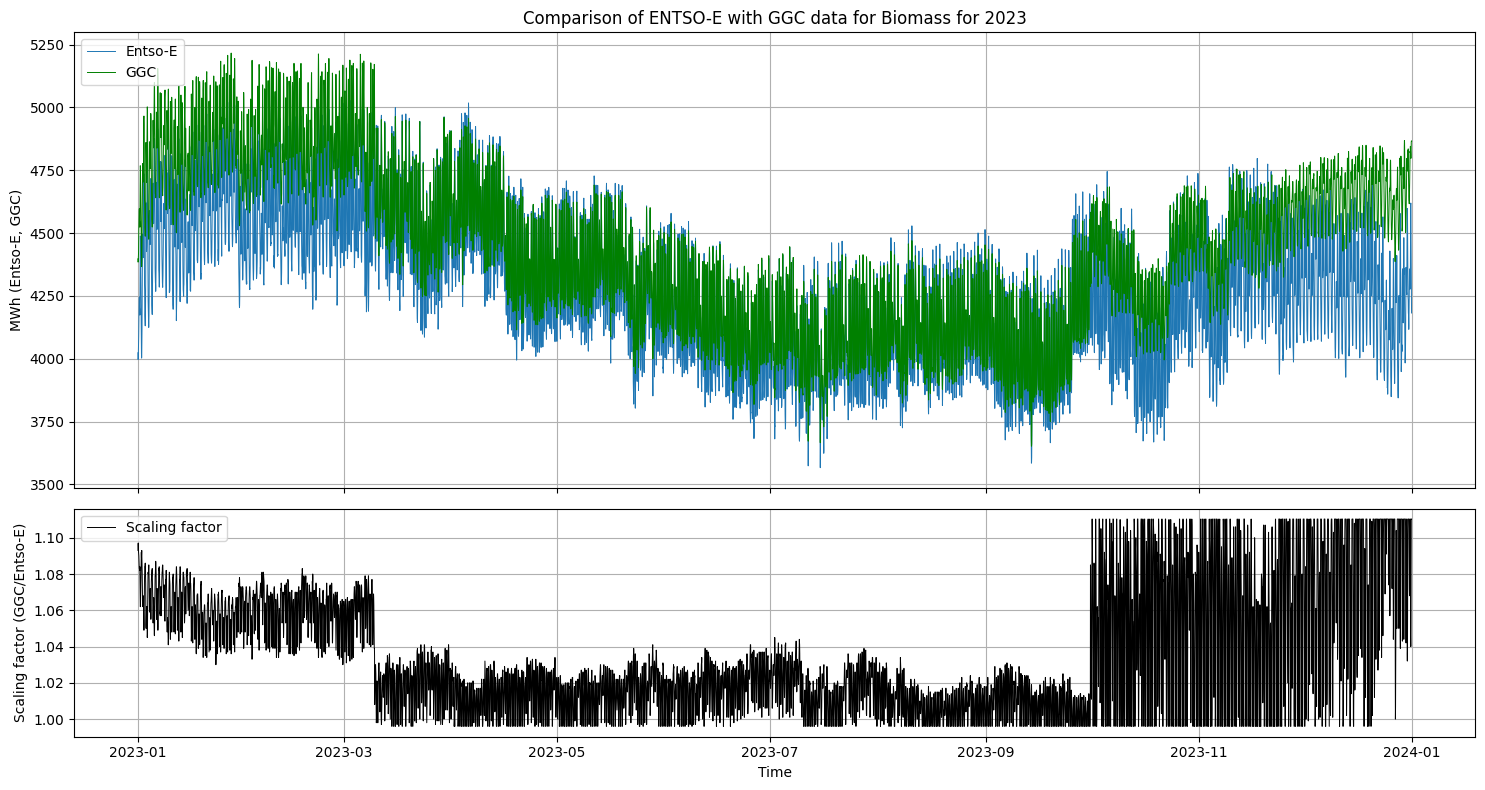

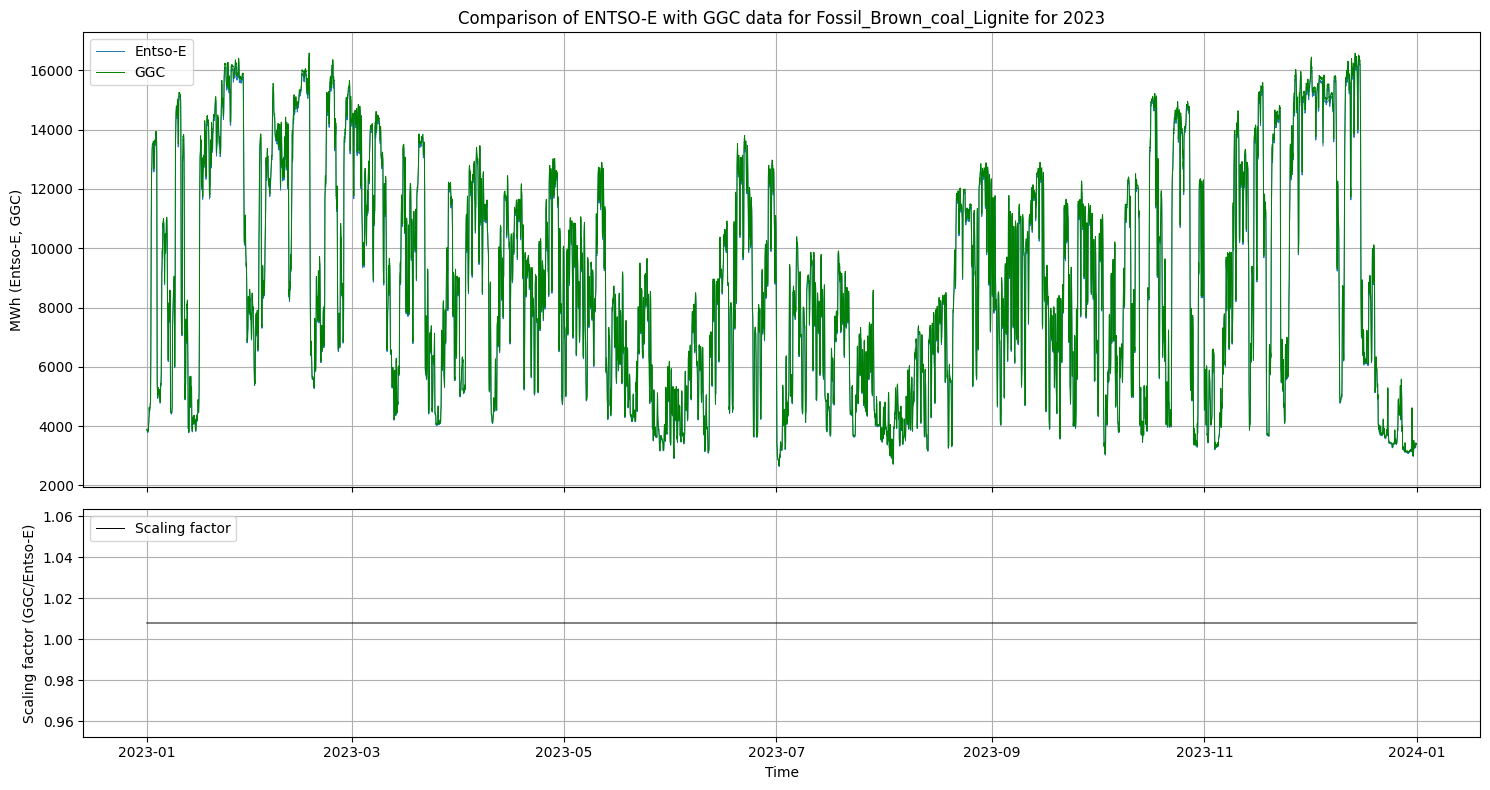

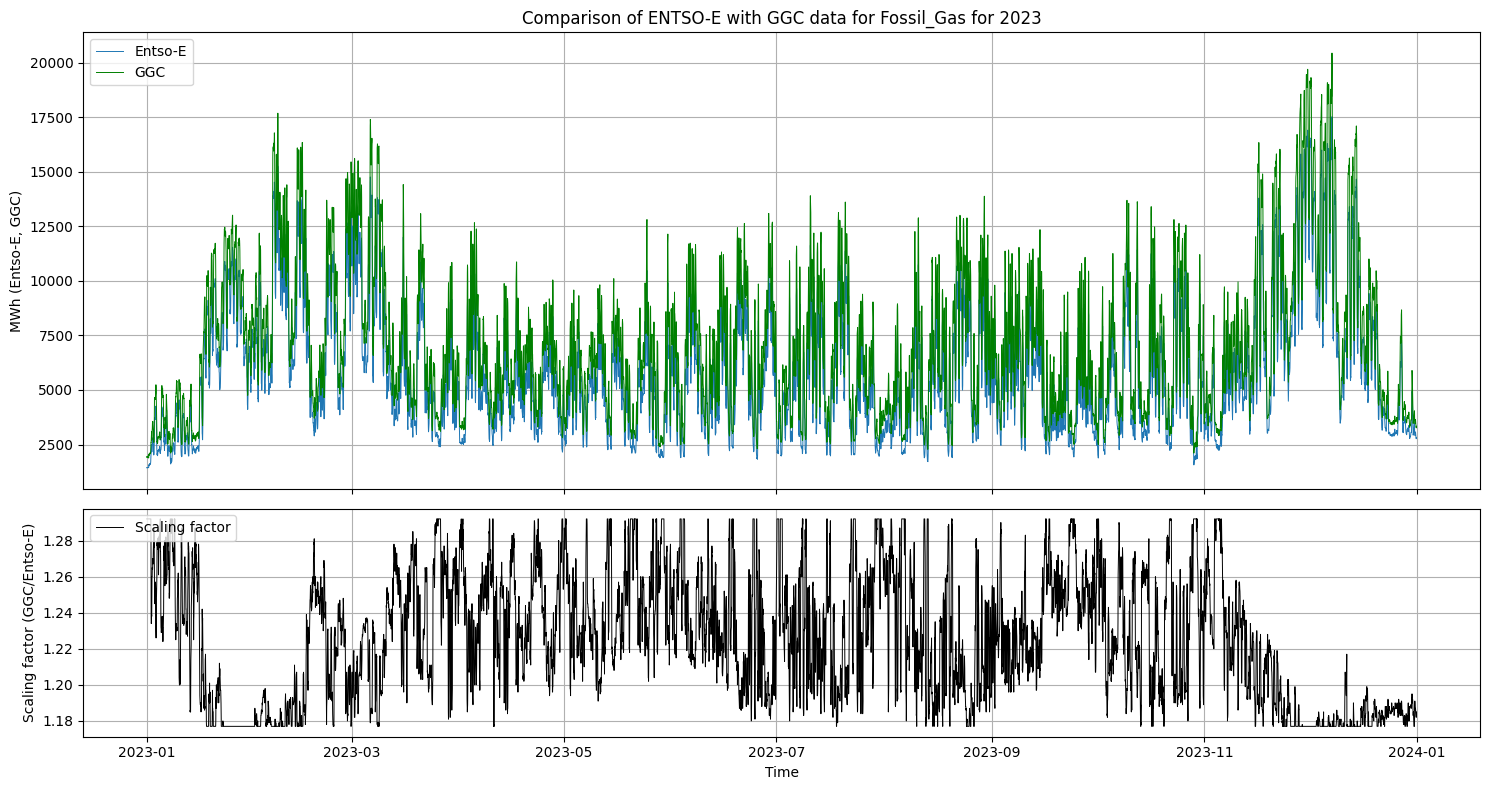

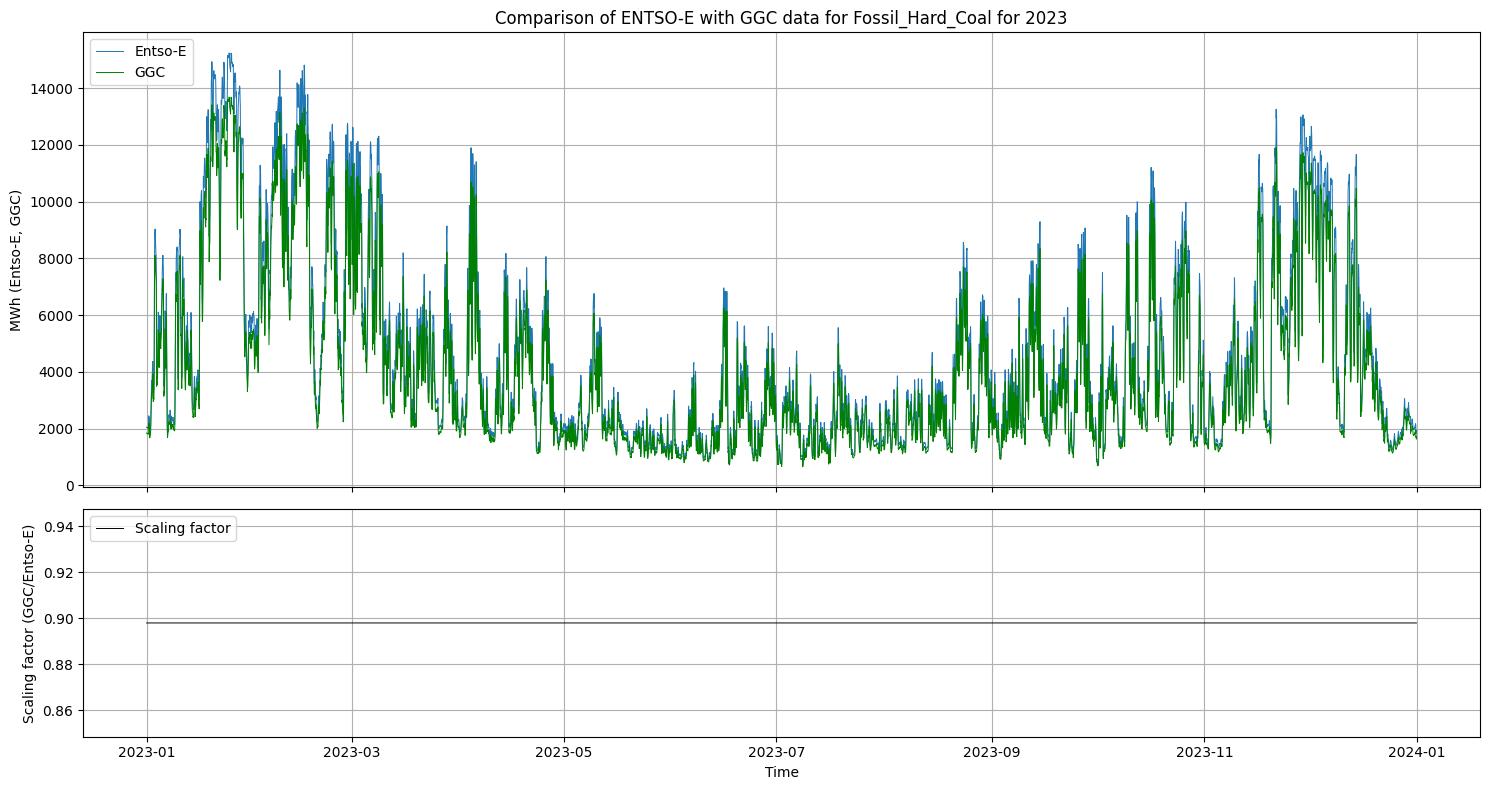

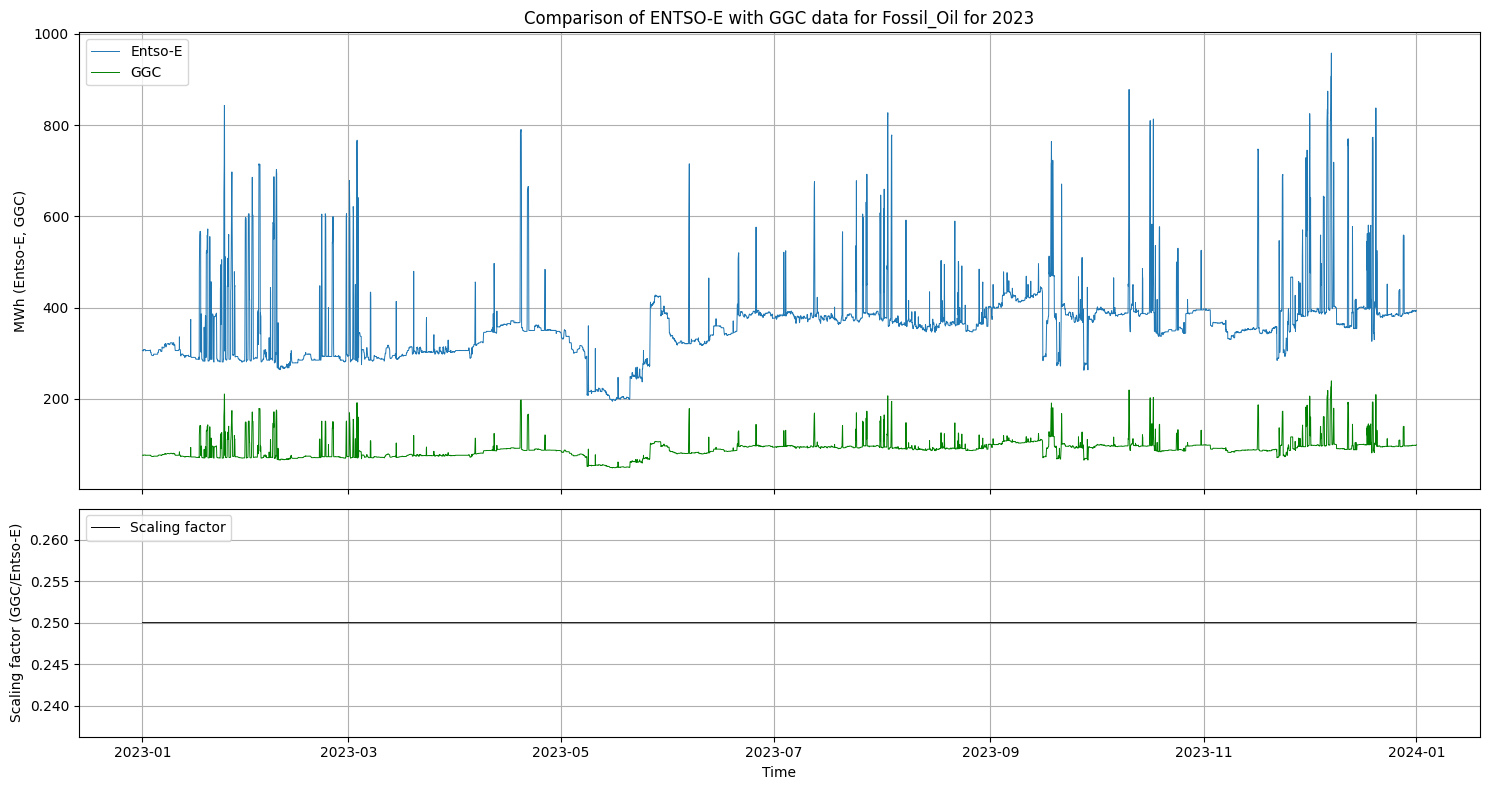

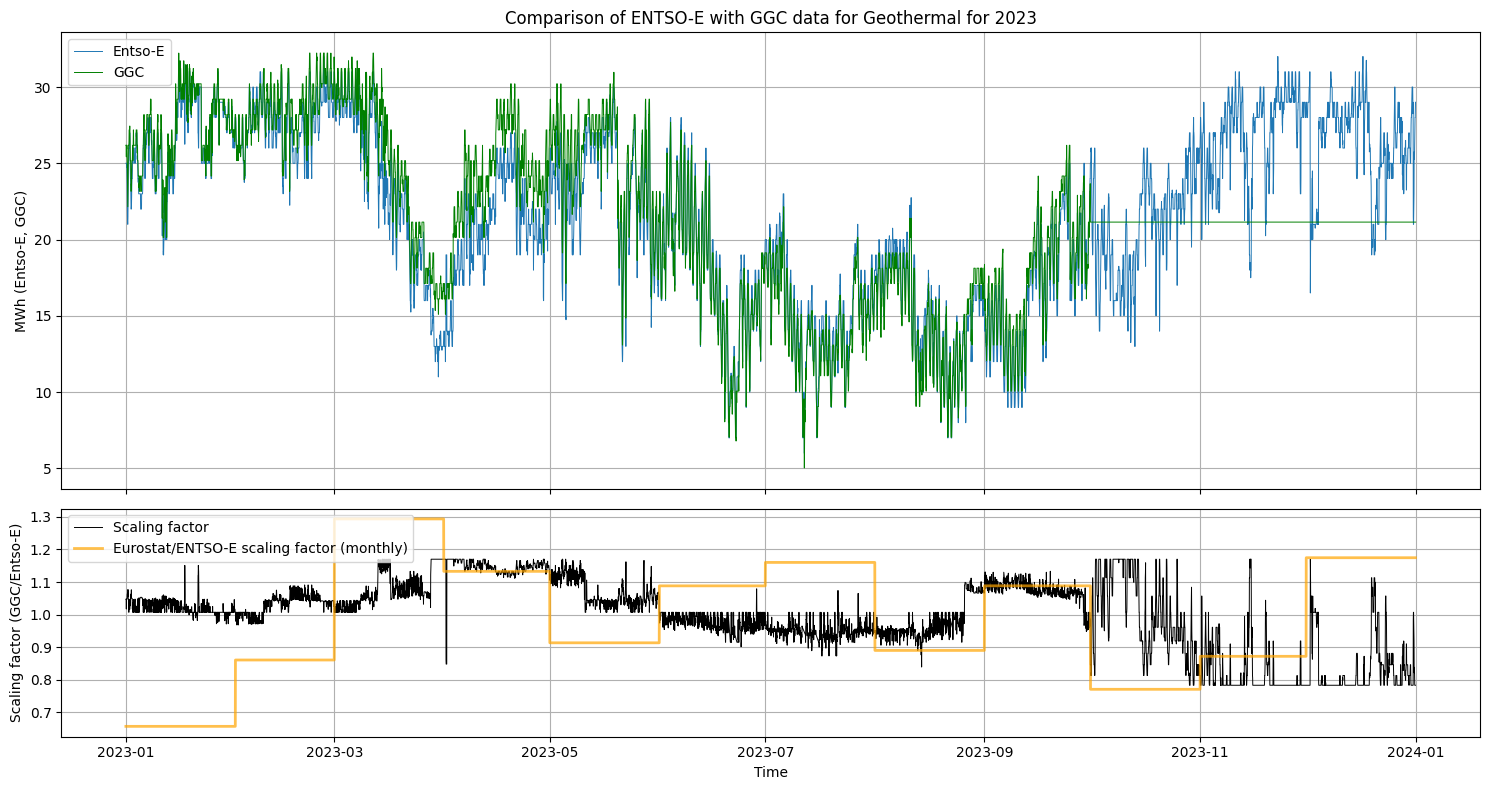

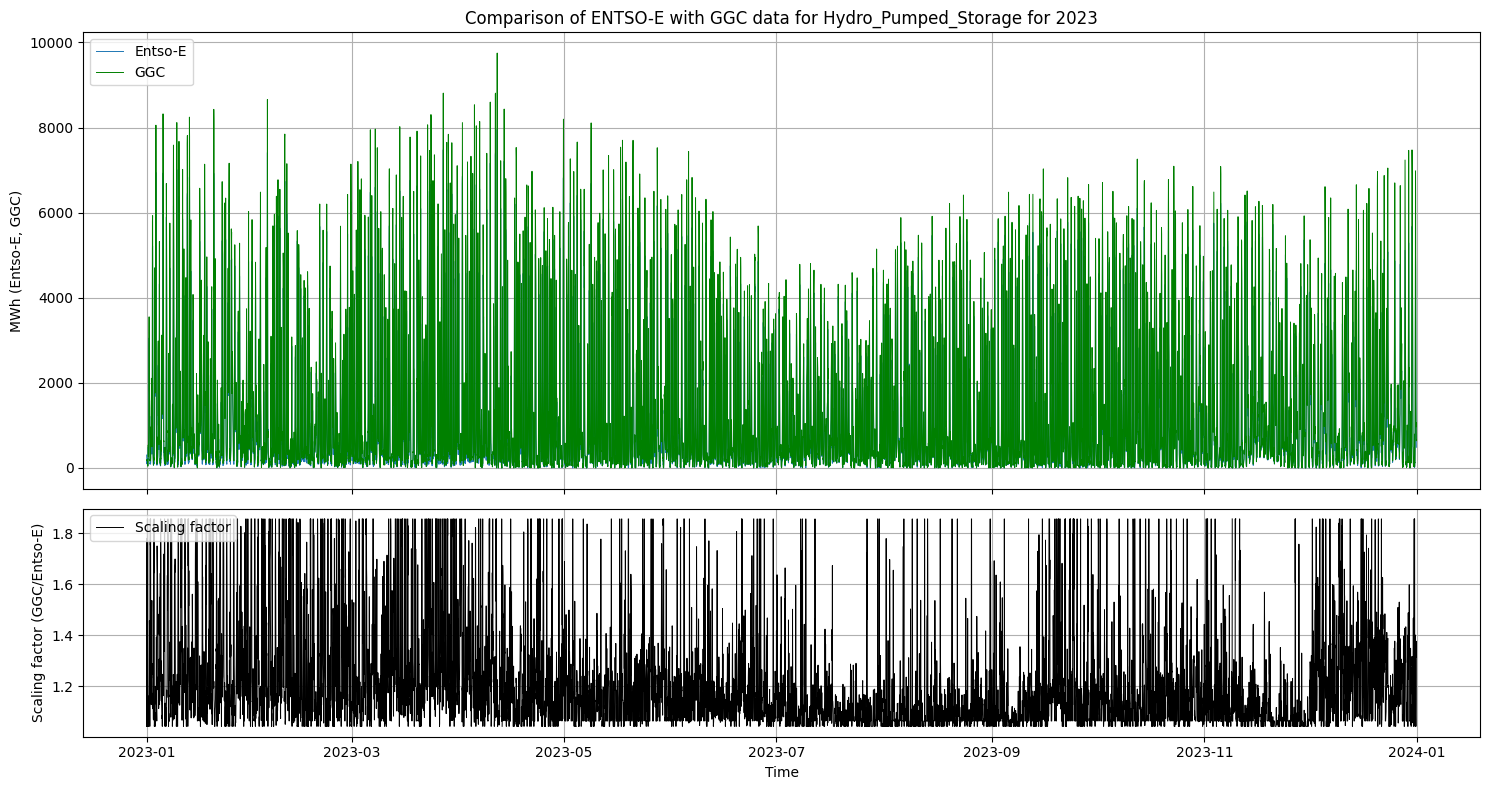

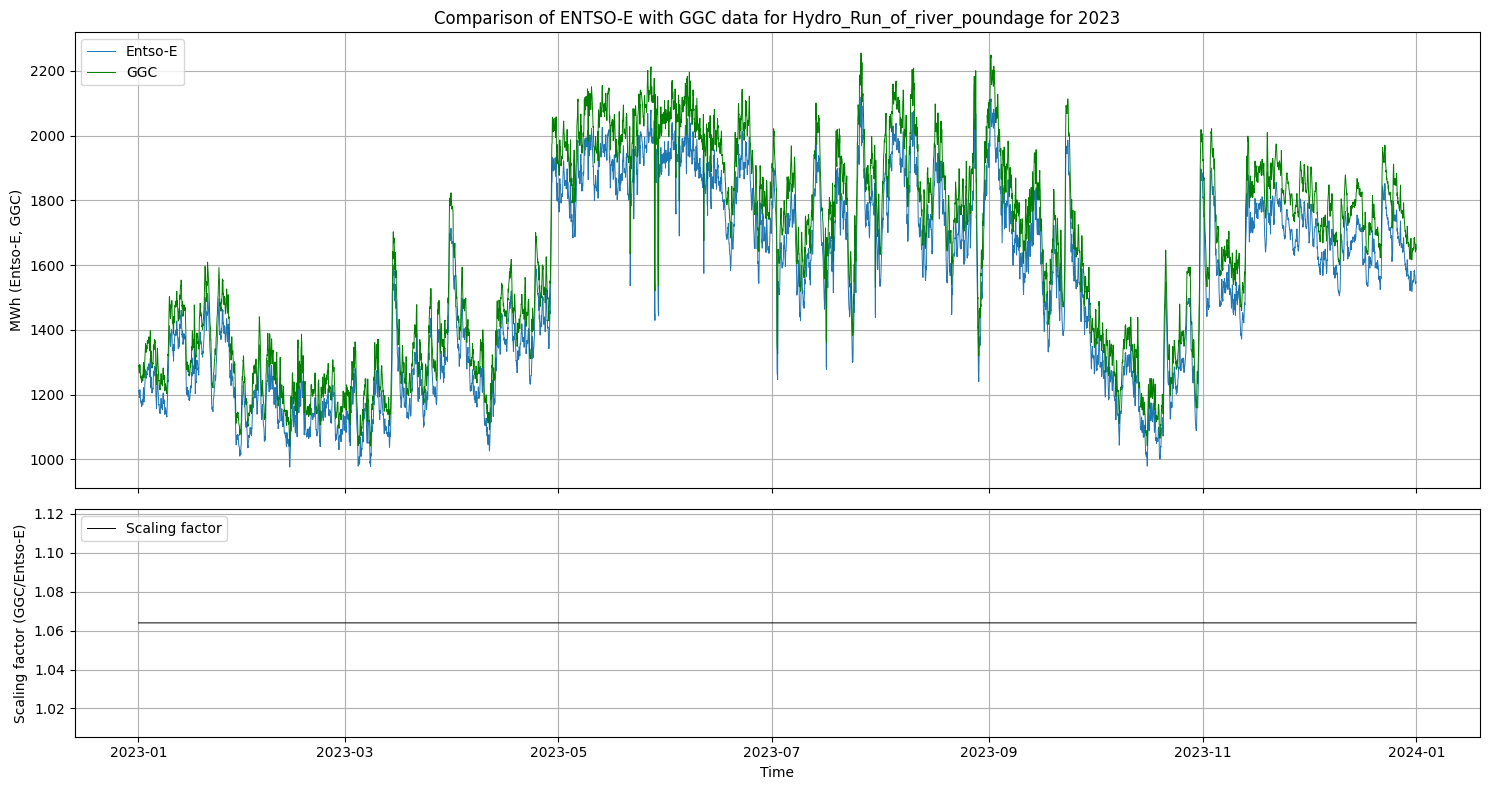

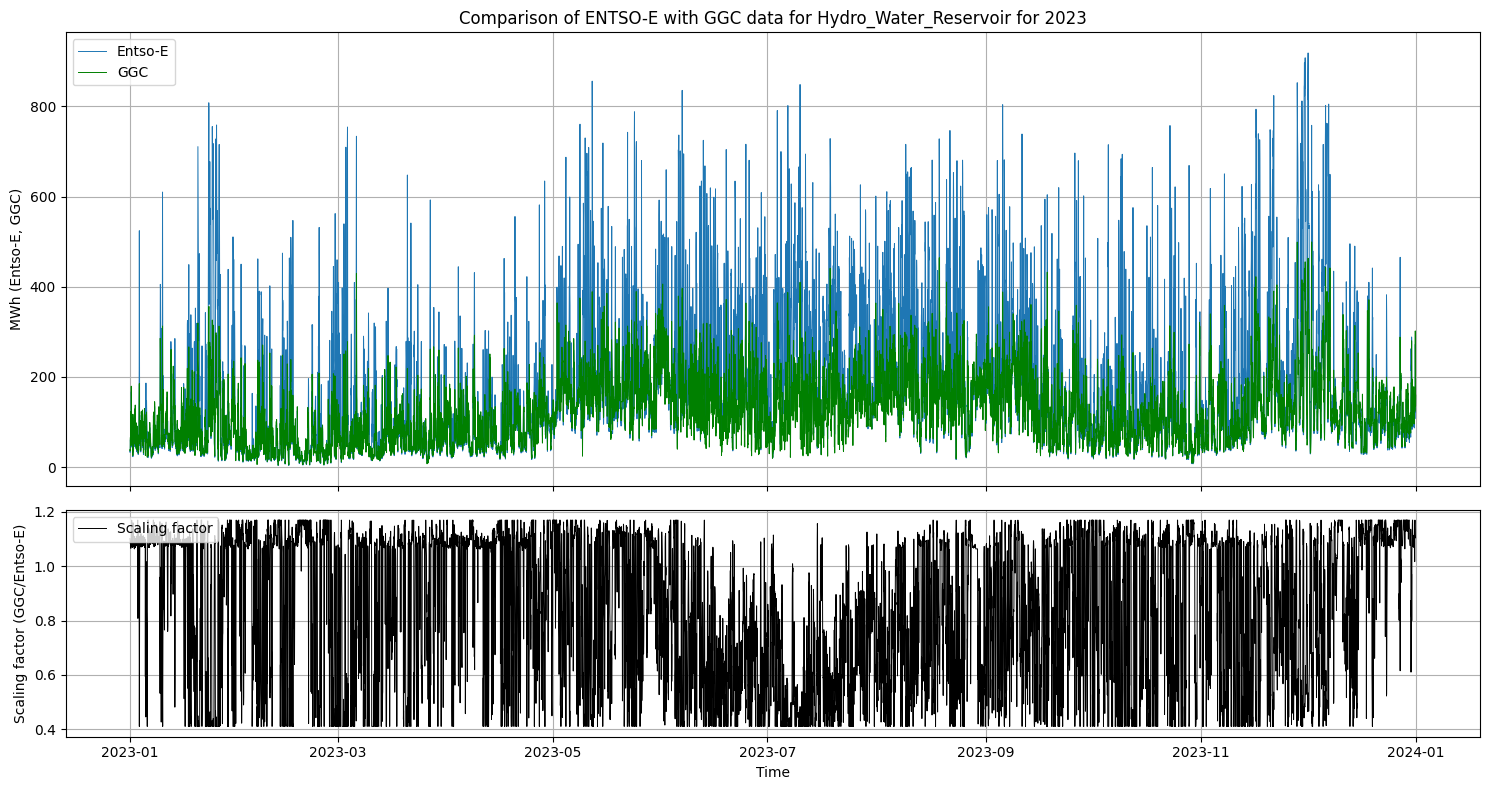

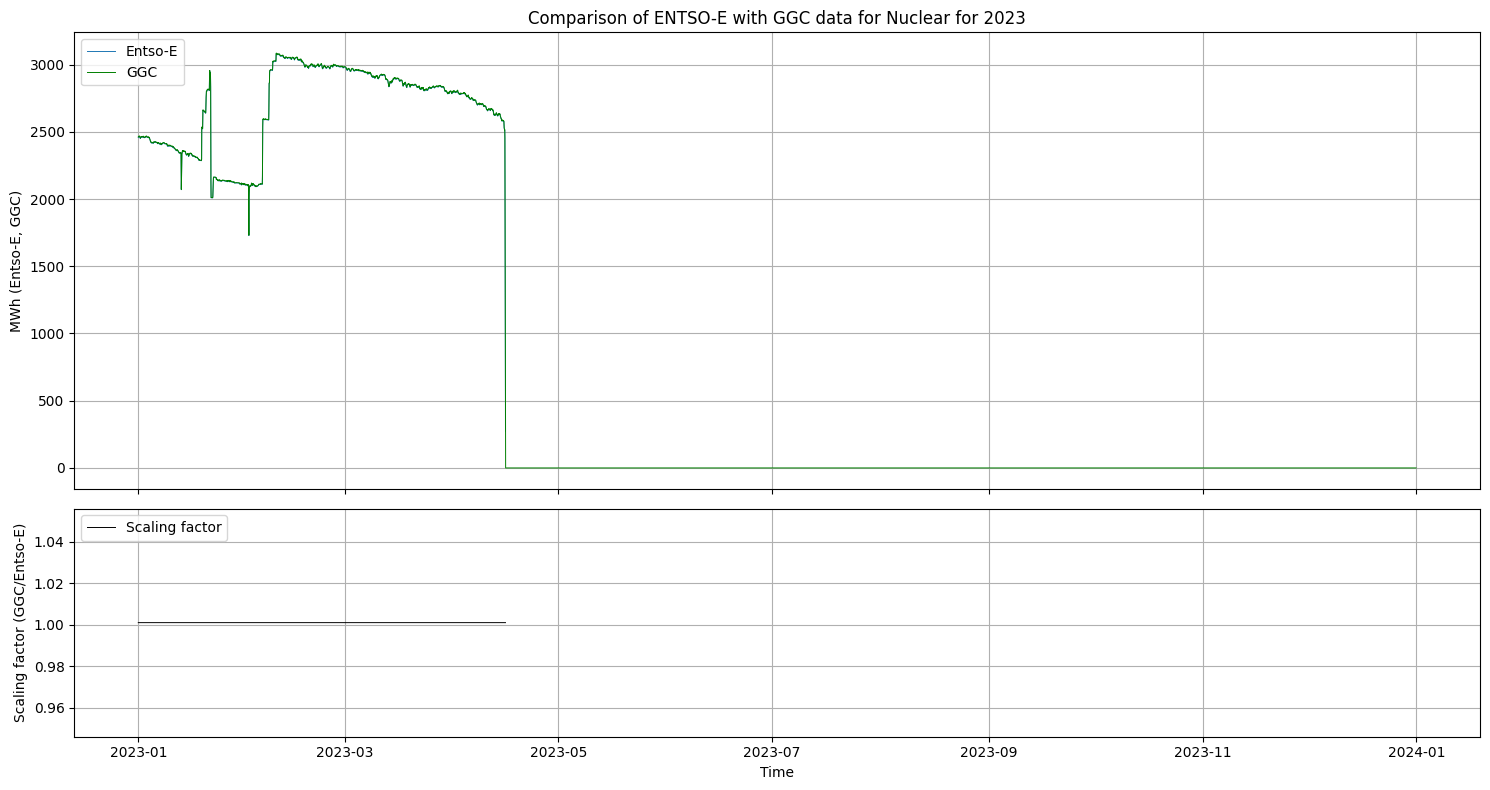

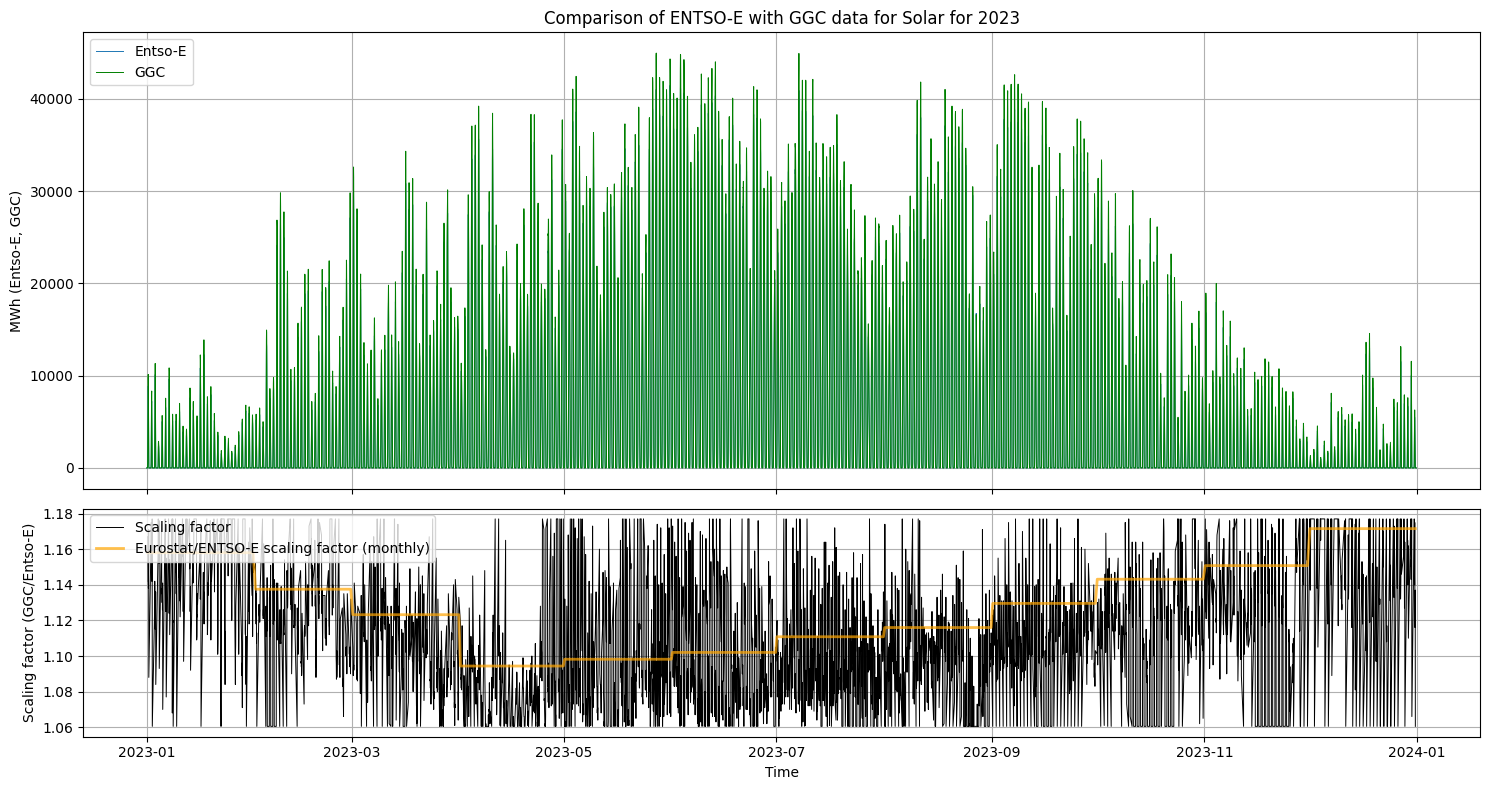

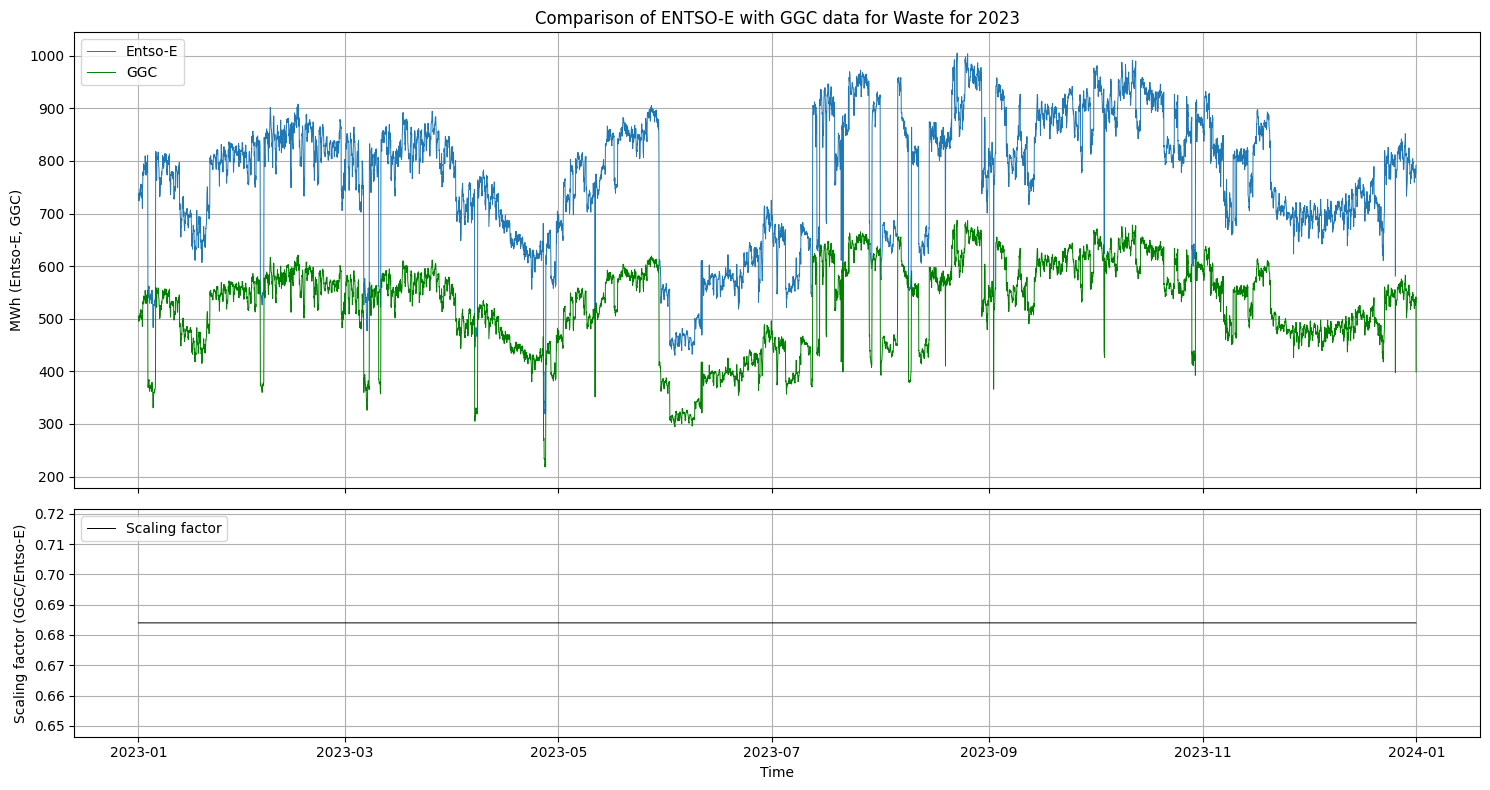

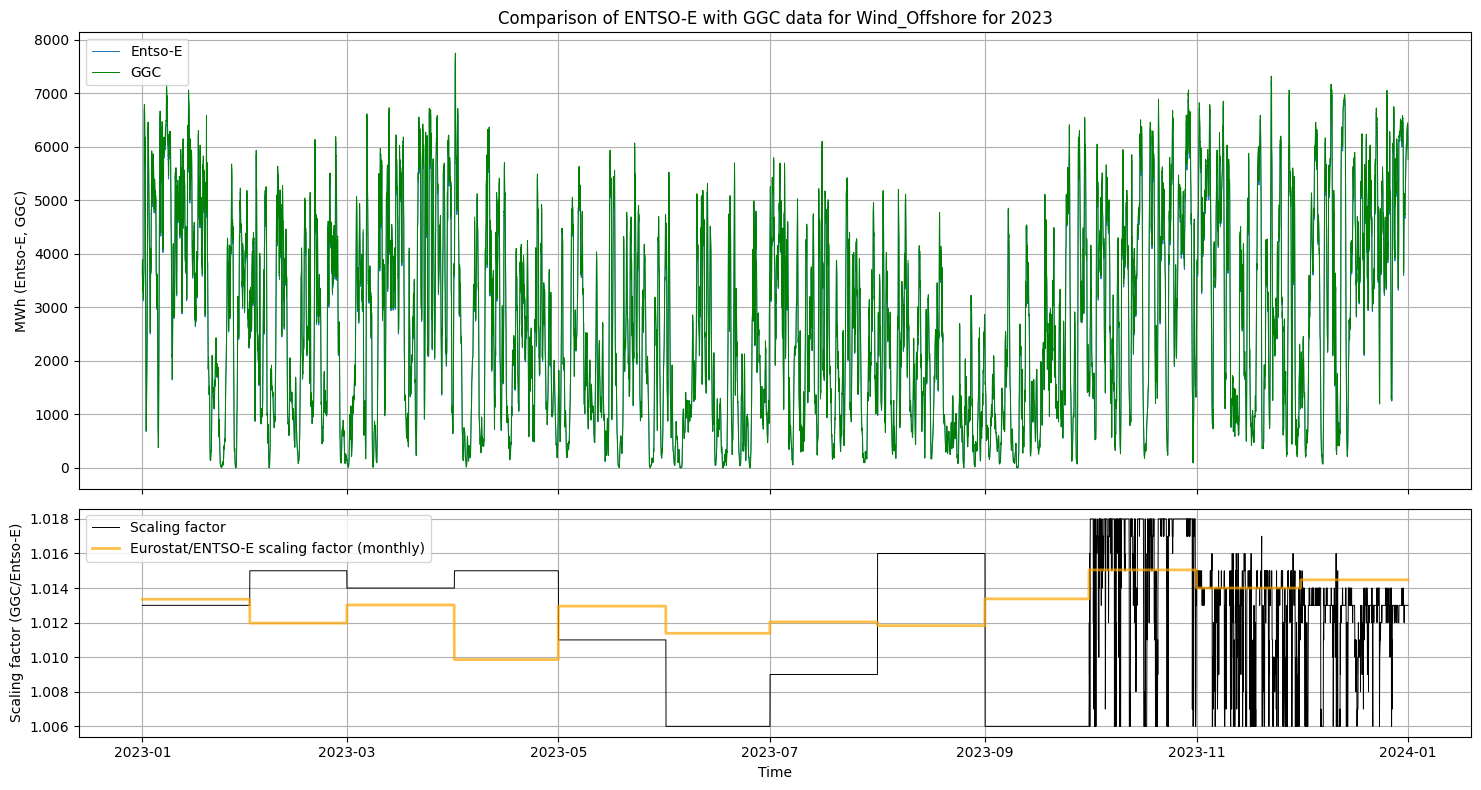

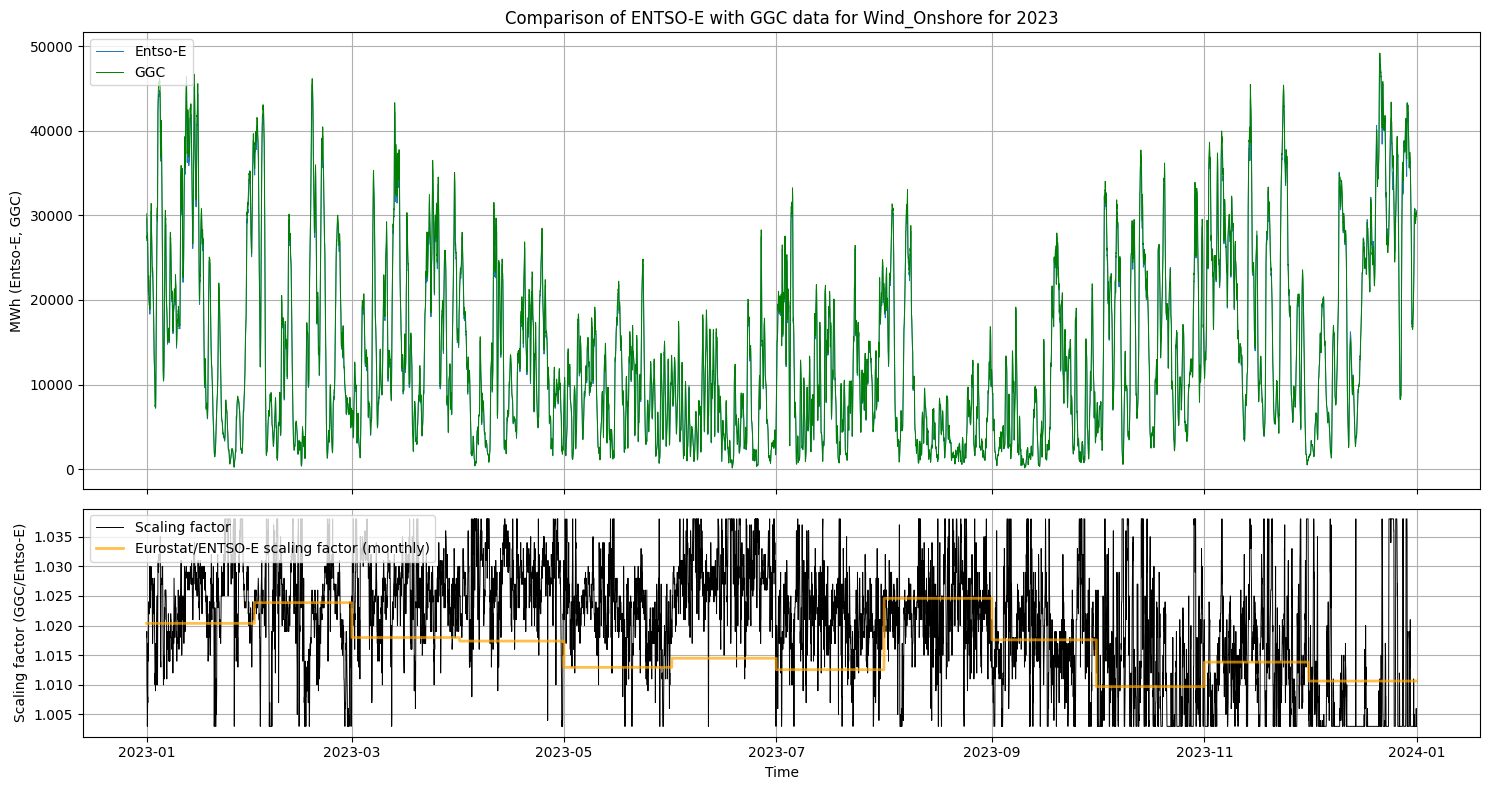

In [ ]:
# Loop through variables and plot
for var in variable_list:
  # Assigning variables from the dictionary
  time_type = var["Time"]
  ggc_var = var["GGC"]
  entsoe_var = var["ENTSOE"]
  eurostat_fuel_code = var["EUROSTAT"] if pd.notna(var["EUROSTAT"]) and var["EUROSTAT"] != "" else None

  # ENTSO-E hourly mean
  df_entsoe[entsoe_var] = pd.to_numeric(df_entsoe[entsoe_var], errors='coerce')
  hourly_mean = df_entsoe[entsoe_var].resample('h').mean().shift(-1)

  # Align indices for plotting
  common_index = df_ggc_aligned.index.intersection(hourly_mean.index)
  df_aligned = df_ggc_aligned.loc[common_index]
  hourly_mean_aligned = hourly_mean.loc[common_index]

  # Scaling factor calculation
  scale = df_aligned[ggc_var] / hourly_mean_aligned

  # Only plotting values above a threshold for renewables
  if time_type == "M":
      threshold = 10 # To be set in MWh
      valid_mask = (df_aligned[ggc_var] > threshold) & (hourly_mean_aligned > threshold)
      scale = scale[valid_mask]
  scale = scale.round(3)

  # Eurostat calculation (for monthly scaling factor)
  if time_type == "M" and eurostat_fuel_code is not None:
      df_euro = eurostat_net(year, eurostat_fuel_code) # Load the dataframe
      # Aggregating monthly values for DE+LU
      df_euro["OBS_VALUE"] = pd.to_numeric(df_euro["OBS_VALUE"], errors="coerce")
      eurostat_monthly = (
          df_euro.groupby("TIME_PERIOD")["OBS_VALUE"]
          .sum()
          .sort_index()
      )
      # Aggregating monthly ENTSO-E values
      monthly_entsoe = (
          df_entsoe[entsoe_var]
          .resample('ME')
          .sum()
          .div(4000) # Converting to GWh to align with EUROSTAT Data
      )
      monthly_entsoe.index = monthly_entsoe.index.strftime(f"{year}-%m") # Adjust according to year
      monthly_entsoe = monthly_entsoe.loc[eurostat_monthly.index]
      # Calculating monthly scaling factor
      monthly_scaling_factor = eurostat_monthly / monthly_entsoe
      # To plot constant scaling values across the month
      monthly_scaling_hourly = pd.Series(index=scale.index, dtype=float)
      for period, factor in monthly_scaling_factor.items():
          month = int(period.split('-')[1])
          idx = (scale.index.month == month)
          monthly_scaling_hourly[idx] = factor
  else:
      monthly_scaling_hourly = None

  # Creating two plots over the same time frame values
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

  # First plot: GGC and Entso-E values
  ax1.plot(hourly_mean_aligned.index, hourly_mean_aligned.values, label='Entso-E', linewidth=0.7)
  ax1.plot(df_aligned.index, df_aligned[ggc_var].values, label='GGC', linewidth=0.7, color='g')
  ax1.set_ylabel('MWh (Entso-E, GGC)')
  ax1.grid(True)
  ax1.legend(loc='upper left')
  ax1.set_title(f'Comparison of ENTSO-E with GGC data for {ggc_var} for {year}')

  # Second plot: Scaling factor
  ax2.plot(scale.index, scale.values, label='Scaling factor', linewidth=0.7, color='k')
  if monthly_scaling_hourly is not None:
      ax2.plot(monthly_scaling_hourly.index, monthly_scaling_hourly.values, label='Eurostat/ENTSO-E scaling factor (monthly)', linewidth=2, color='orange', alpha=0.7)
  ax2.set_ylabel('Scaling factor (GGC/Entso-E)')
  ax2.set_xlabel('Time')
  ax2.grid(True)
  ax2.legend(loc='upper left')
  plt.tight_layout()
  plt.show()